<a href="https://colab.research.google.com/github/irene-30/DLAI/blob/main/Copia_di_02_vqvae_training_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. VQ-VAE Training (Stage 1)

**Objective:** Train the VQ-VAE model from `src.model.vae` on the full `P+C+S` sequences. We will run a small training loop here, plot the losses, and save the final model weights to `experiments/vqvae_stage1.pth`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/irene-30/DLAI.git
%cd /content/DLAI

Cloning into 'DLAI'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 161 (delta 57), reused 133 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (161/161), 42.67 KiB | 910.00 KiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/DLAI


In [3]:
%pip install datasets transformers torch tqdm matplotlib

In [5]:
import sys
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Add 'src' to path
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.utils import (
    get_llm_tokenizer, MAX_SEQ_LEN, PATH_VQVAE_MODEL,
    VQ_CODEBOOK_SIZE
)
from src.dataset import Lazy_VQVAE_Dataset
from src.model.vae import VQVAEModel

# --- Configuration ---
D_MODEL = 256
NUM_EPOCHS = 30 # Increase for a real run
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2.1 Load Tokenizer and Dataset

In [6]:
tokenizer = get_llm_tokenizer()
vocab_size = len(tokenizer)

print(f"Tokenizer vocabulary size (including new tokens): {vocab_size}")

raw_dataset = load_dataset("gsm8k", "main")['train']
train_dataset = Lazy_VQVAE_Dataset(tokenizer, raw_dataset, max_length=MAX_SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Loaded {len(train_dataset)} samples for VQ-VAE training.")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer vocabulary size (including new tokens): 51284


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Loaded 7473 samples for VQ-VAE training.


## 2.2 Initialize Model and Optimizer

In [7]:
model = VQVAEModel(
    vocab_size=vocab_size,
    d_model=D_MODEL,
    num_embeddings=VQ_CODEBOOK_SIZE,
    max_seq_len=MAX_SEQ_LEN
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"VQ-VAE Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

VQ-VAE Model parameters: 30.52M


## 2.3 Training Loop

We'll run the training loop directly in the notebook to monitor its progress and plot the losses.

In [8]:
model.train()
losses = []
recon_losses = []
vq_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"--- EPOCH {epoch+1}/{NUM_EPOCHS} ---")
    epoch_loss, epoch_recon, epoch_vq = 0, 0, 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)

        optimizer.zero_grad()

        total_loss, recon_loss, vq_loss = model(input_ids)

        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        epoch_recon += recon_loss.item()
        epoch_vq += vq_loss.item()

    # Log average losses for the epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_vq = epoch_vq / len(train_loader)

    losses.append(avg_loss)
    recon_losses.append(avg_recon)
    vq_losses.append(avg_vq)

    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | VQ: {avg_vq:.4f}")

--- EPOCH 1/30 ---


100%|██████████| 468/468 [08:01<00:00,  1.03s/it]


Epoch 1 | Avg Loss: 2.6196 | Recon: 1.4855 | VQ: 1.1340
--- EPOCH 2/30 ---


100%|██████████| 468/468 [08:04<00:00,  1.04s/it]


Epoch 2 | Avg Loss: 1.6822 | Recon: 0.8303 | VQ: 0.8519
--- EPOCH 3/30 ---


100%|██████████| 468/468 [08:04<00:00,  1.03s/it]


Epoch 3 | Avg Loss: 1.4053 | Recon: 0.7568 | VQ: 0.6485
--- EPOCH 4/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 4 | Avg Loss: 1.1865 | Recon: 0.7145 | VQ: 0.4720
--- EPOCH 5/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 5 | Avg Loss: 1.0377 | Recon: 0.6868 | VQ: 0.3510
--- EPOCH 6/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 6 | Avg Loss: 0.9306 | Recon: 0.6658 | VQ: 0.2648
--- EPOCH 7/30 ---


100%|██████████| 468/468 [08:05<00:00,  1.04s/it]


Epoch 7 | Avg Loss: 0.8432 | Recon: 0.6498 | VQ: 0.1934
--- EPOCH 8/30 ---


100%|██████████| 468/468 [08:05<00:00,  1.04s/it]


Epoch 8 | Avg Loss: 0.7647 | Recon: 0.6351 | VQ: 0.1297
--- EPOCH 9/30 ---


100%|██████████| 468/468 [08:05<00:00,  1.04s/it]


Epoch 9 | Avg Loss: 0.7066 | Recon: 0.6221 | VQ: 0.0845
--- EPOCH 10/30 ---


100%|██████████| 468/468 [08:05<00:00,  1.04s/it]


Epoch 10 | Avg Loss: 0.6663 | Recon: 0.6099 | VQ: 0.0563
--- EPOCH 11/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 11 | Avg Loss: 0.6371 | Recon: 0.5993 | VQ: 0.0378
--- EPOCH 12/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 12 | Avg Loss: 0.6153 | Recon: 0.5897 | VQ: 0.0256
--- EPOCH 13/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 13 | Avg Loss: 0.5966 | Recon: 0.5788 | VQ: 0.0178
--- EPOCH 14/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 14 | Avg Loss: 0.5824 | Recon: 0.5691 | VQ: 0.0133
--- EPOCH 15/30 ---


100%|██████████| 468/468 [08:07<00:00,  1.04s/it]


Epoch 15 | Avg Loss: 0.5710 | Recon: 0.5591 | VQ: 0.0119
--- EPOCH 16/30 ---


100%|██████████| 468/468 [08:06<00:00,  1.04s/it]


Epoch 16 | Avg Loss: 0.5614 | Recon: 0.5494 | VQ: 0.0119
--- EPOCH 17/30 ---


100%|██████████| 468/468 [08:07<00:00,  1.04s/it]


Epoch 17 | Avg Loss: 0.5541 | Recon: 0.5412 | VQ: 0.0129
--- EPOCH 18/30 ---


100%|██████████| 468/468 [08:05<00:00,  1.04s/it]


Epoch 18 | Avg Loss: 0.5455 | Recon: 0.5320 | VQ: 0.0135
--- EPOCH 19/30 ---


 10%|▉         | 46/468 [00:49<07:29,  1.07s/it]


KeyboardInterrupt: 

## 2.4 Visualize Losses

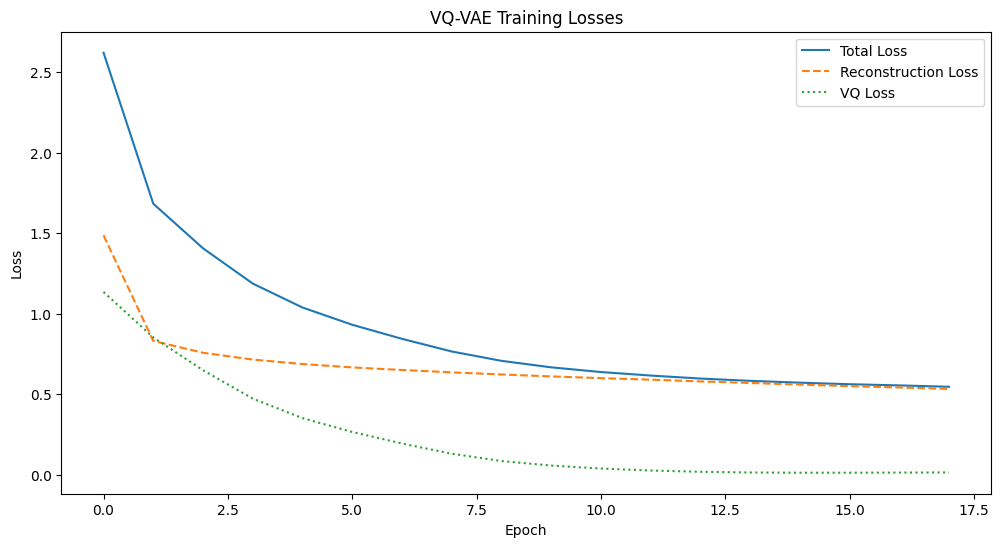

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction Loss', linestyle='--')
plt.plot(vq_losses, label='VQ Loss', linestyle=':')
plt.title('VQ-VAE Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2.5 Save the Model

Finally, we save the trained VQ-VAE weights. These will be loaded by the next notebook to create the assorted dataset.

In [11]:
#print(f"Saving VQ-VAE model to {PATH_VQVAE_MODEL}")
#os.makedirs(os.path.dirname(PATH_VQVAE_MODEL), exist_ok=True)
#torch.save(model.state_dict(), PATH_VQVAE_MODEL)
#print("Model saved.")

Saving VQ-VAE model to experiments/vqvae_stage1.pth
Model saved.


In [10]:
import os
drive_save_folder = "/content/drive/My Drive/DLAI/experiments/"

# 2. Assicurati che la cartella esista (la crea se non c'è)
os.makedirs(drive_save_folder, exist_ok=True)

# 3. Definisci il nome completo del file
final_model_path = os.path.join(drive_save_folder, "vqvae_stage1.pth")

# 4. Salva il modello usando il percorso assoluto
print(f"Sto salvando il modello direttamente su Google Drive in:")
print(f"{final_model_path}")

torch.save(model.state_dict(), final_model_path)

print("--- Modello salvato con successo su Google Drive! ---")

Sto salvando il modello direttamente su Google Drive in:
/content/drive/My Drive/DLAI/experiments/vqvae_stage1.pth
--- Modello salvato con successo su Google Drive! ---
